In [2]:
# Imports are just like before
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open('names.txt', 'r').read().splitlines() # read in all the words
print(words[:8])           # Show the first eight words
print(len(words), 'words') # Total amount of words in our dataset

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
32033 words


In [4]:
# Build a vocabulary of characters map them to integers
chars = sorted(list(set(''.join(words))))  # set(): Throwing out letter duplicates

stoi = {s:i+1 for i,s in enumerate(chars)} # Make tupels of type (char, counter)
stoi['.'] = 0                              # Add this special symbol's entry explicitly
itos = {i:s for s,i in stoi.items()}       # Switch order of (char, counter) to (counter, char)

vocab_size = len(itos)

# Showing the two mappings, they really just are mirrors of one another
print(itos)
print(stoi)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
27


In [5]:
# Build the dataset
import random
block_size = 3  # Context length: How many characters do we take to predict the next one?


def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # Crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    print(X.shape, Y.shape)
    return X, Y


# Randomize the dataset (with reproducibility)
random.seed(42)
random.shuffle(words)

# These are the "markers" we will use to divide the dataset
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

# Dividing the dataset into train, dev and test splits
Xtr, Ytr = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])  # 10%
Xte, Yte = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
n_embd = 10    # dimensionality of the character embedding vectors
n_hidden = 200 # number of neurons in the hidden layer of the MLP

g  = torch.Generator().manual_seed(2147483647)                 # For reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g) # 27 letters x 10 values inp layer
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) # 10 values x 3 priors x 200 neur.
b1 = torch.randn(n_hidden,                        generator=g) # 200 biases for the 200 neurons
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # 200 inputs x 27 output neurons
b2 = torch.randn(vocab_size,                      generator=g) * 0# 27 output biases

parameters = [C, W1, b1, W2, b2] # Cluster all parameters into one structure
print(sum(p.nelement() for p in parameters), 'parameters') # total parameters (3481 before)

for p in parameters:
    p.requires_grad = True


11897 parameters


In [7]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # mini-batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # X,Y of this batch
    
    # Forward-Pass
    emb = C[Xb]                         # Embedding characters into vectors
    embcat = emb.view(emb.shape[0], -1) # Concatenate the vectors
    hpreact = embcat @ W1 + b1          # Hidden layer pre-activation
    h = torch.tanh(hpreact)             # Hidden layer
    logits = h @ W2 + b2                # Output layer
    loss = F.cross_entropy(logits, Yb)  # Loss function
    
    # Backward-Pass
    for p in parameters:
        p.grad = None # Making sure that prior iteration's gradients are gone
    loss.backward()   # This calculates the current (new) gradients
    
    # Update
    lr = 0.1 if i < (max_steps / 2) else 0.01 # Learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # Printing track stats every once in a while
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    
    # Adding current loss value to historic losses set (for later display)
    lossi.append(loss.log10().item())
    break


      0/ 200000: 3.3221


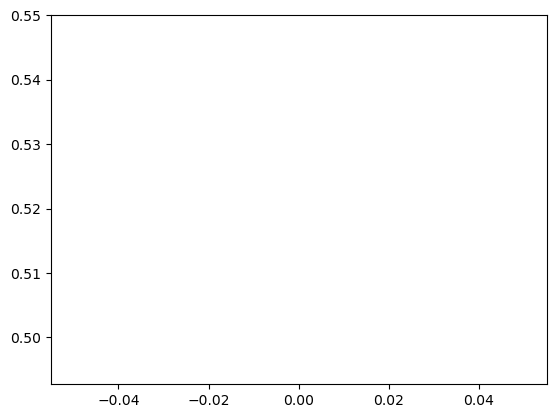

In [8]:
plt.plot(lossi)

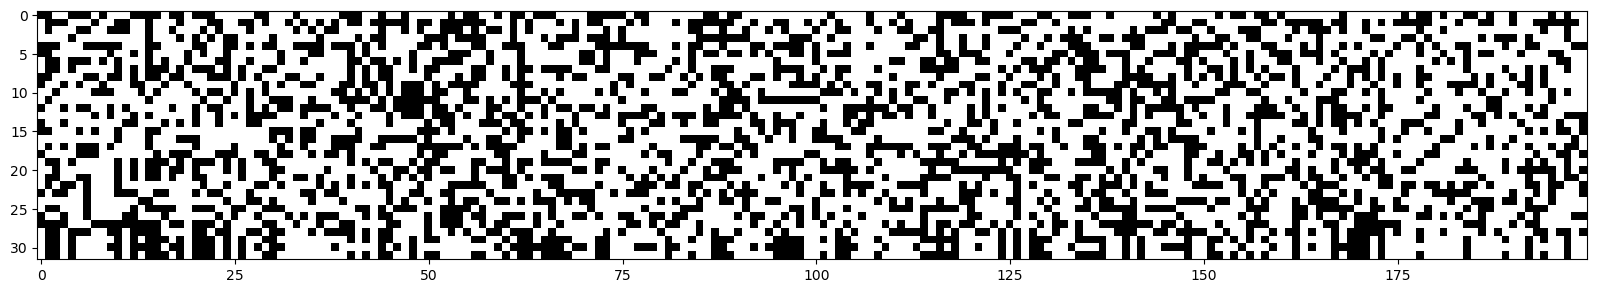

In [9]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest') # true: white, false: black (h is 32 x 200)

## loss log

### original:
train 2.1245384216308594
val   2.168196439743042

### fix softmax confidently wrong:
train 2.07
val   2.13

### fix tanh layer too saturated at init:
train 2.0355966091156006
val   2.1026785373687744

In [10]:
# See Makemore #2. We did this before but it's refactored here for convenience:
@torch.no_grad() # Decorator, disables gradient tracking (no "book-keeping" on torch's side)
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]    # That's a switch (never seen it like this!)
    
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # Concatenate into (N, block_size * n_embd)
    
    h = torch.tanh(embcat @ W1 + b1)    # (N, n_hidden)
    logits = h @ W2 + b2                # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 3.1878931522369385
val 3.187795877456665


In [11]:
# Sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size  # initialize with all ...
    while True:
        # Forward pass the neural net
        emb = C[torch.tensor([context])]  # (1,block_size,n_embd)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # Sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # Shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # As soon as we sample the special '.' token, break
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))  # Decode and print the generated word

erbuagmyazzszevvndhfyaloqetursjejgrlrg.
ozcjedgeliihsmpqppaledeixvqnpxarveptzkmhvqrpcn.
szdbvrgxhgmjest.
j.
jrwjkjqqxntpucfkubzkgvdtrxyqqufzehg.
kmejqvskkydvzhjl.
cakyybsufpzbjhlvjuren.
crtvwsvevoecmpfvdxrfqyxoeobhggptixjsfcueywwkhmreolbii.
qiif.
evpkxwvlla.
ortabfsztjnegoikvsblitbfkxvbssivpu.
oeelrkepxcmvy.
xavttudkjgczekhgkgtipvtudt.
iwbddihzvorlq.
hjakepaugniagcrpcpfmiipzjgvonxet.
jydnblksqzporygvogsvmwosfzybsyknymjcxtkncjbmu.
etew.
aow.
copmrlxkzdcqbcep.
ccdfivsnvpimhtewmos.


########################################################################################################

In [50]:
# Linear Layer Definition (mimicing torch.nn.Linear's structure)
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        # Weights with Kaiming just like above would be (W1 * (5/3)/((n_embd * block_size)**0.5))
        # The term (5/3) is still missing, but that's because we don't have a non-linearity here yet
        # We'll add it later
        self.weight = torch.randn(
            (fan_in, fan_out), generator=g) / fan_in ** 0.5
        # Biases are optional here
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight  # W*x
        if self.bias is not None:  # Add biases if so desired
            self.out += self.bias
        return self.out

    def parameters(self):
        # return layer's tensors
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [34]:
class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps            # Epsilon set to PyTorch default, you may change it
        self.momentum = momentum  # Momemtum set to PyTorch default, you may change it
        self.training = True
        # Initialize Parameters (trained with backprop)
        # (bngain -> gamma, bnbias -> beta)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # Initialize Buffers
        # (Trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # Forward-Pass
        if self.training:
            xmean = x.mean(0, keepdim=True)  # Batch mean
            xvar = x.var(0, keepdim=True)   # Batch variance
        else:
            xmean = self.running_mean  # Using the running mean as basis
            xvar = self.running_var   # Using the running variance as basis

        # Normalize to unit variance
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta  # Apply batch gain and bias

        # Update the running buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * \
                    self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * \
                    self.running_var + self.momentum * xvar

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]  # return layer's tensors

In [35]:
# Similar to torch.tanh(), but Class-structure to make later steps easier
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

In [51]:
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 100  # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647)  # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g)

layers = [
    Linear(n_embd * block_size, n_hidden),  Tanh(),
    Linear(n_hidden, n_hidden),  Tanh(),
    Linear(n_hidden, n_hidden),  Tanh(),
    Linear(n_hidden, n_hidden),  Tanh(),
    Linear(n_hidden, n_hidden),  Tanh(),
    Linear(n_hidden, vocab_size),
]

with torch.no_grad():
    # Last layer: make less confident
    layers[-1].weight *= 0.1
    # All other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1#5/3

# Embedding matrix + all parameters in all layers = total involved parameters
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))  # number of parameters in total

# These parameters will be affected by backpropagation
for p in parameters:
    p.requires_grad = True

46497


In [52]:
# Same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # Minibatch-Construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # Batch X,Y

    # Forward-Pass
    emb = C[Xb]  # embed the characters into vectors
    x = emb.view(emb.shape[0], -1)  # concatenate the vectors
    # Stack up the layers in orginal order (one after another)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  # loss function

    # Backward-Pass
    for layer in layers:
        # Stating that non-leaf variable gradients are to be kept/retained for evaluation
        layer.out.retain_grad()  # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    lr = 0.1 if i < 100000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # Tracking stats
    if i % 10000 == 0:  # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())

    break  # Take this out to run full optimization/training

      0/ 200000: 3.2988


layer 0 (    Linear): mean -0.02, std 0.99
layer 2 (    Linear): mean -0.01, std 0.61
layer 4 (    Linear): mean +0.00, std 0.49
layer 6 (    Linear): mean +0.00, std 0.40
layer 8 (    Linear): mean -0.02, std 0.36


Text(0.5, 1.0, 'Activation Distribution')

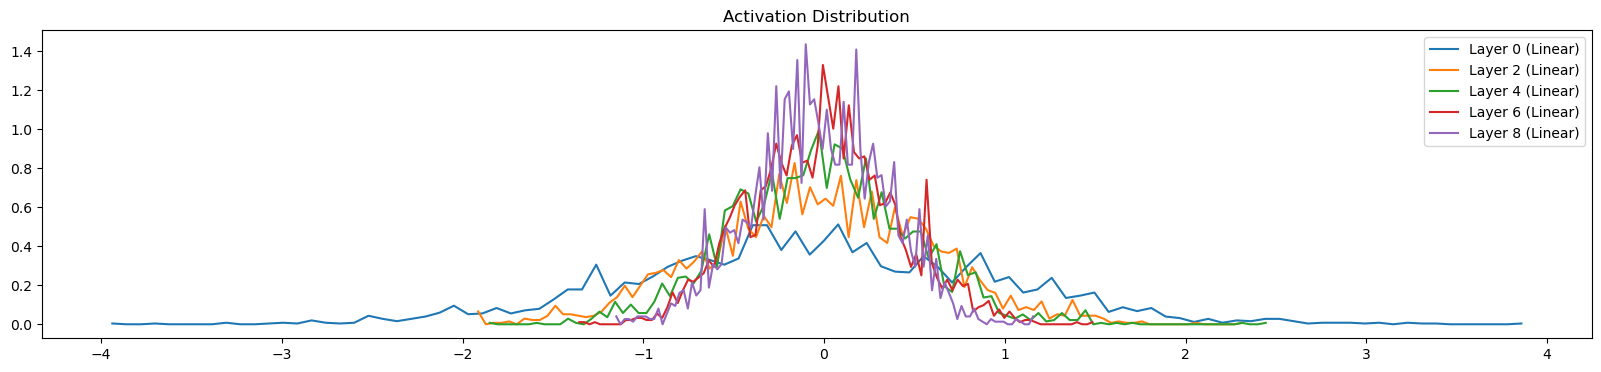

In [53]:
# Visualize histograms (forward pass activations) for the Tanh layers
# (below is what it looks like when Batch-Normalization is needed)
# We can see how many tensor values take on which x-axis values
plt.figure(figsize=(20, 4)) # Width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # Note: Excluding the output layer, these are all Tanh layers
  if isinstance(layer, Linear):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'Layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('Layers Activation Distribution')

layer 1 (      Tanh): mean -0.02, std 0.62, saturated: 3.50%
layer 3 (      Tanh): mean -0.00, std 0.48, saturated: 0.03%
layer 5 (      Tanh): mean +0.00, std 0.41, saturated: 0.06%
layer 7 (      Tanh): mean +0.00, std 0.35, saturated: 0.00%
layer 9 (      Tanh): mean -0.02, std 0.32, saturated: 0.00%


Text(0.5, 1.0, 'Activation Distribution')

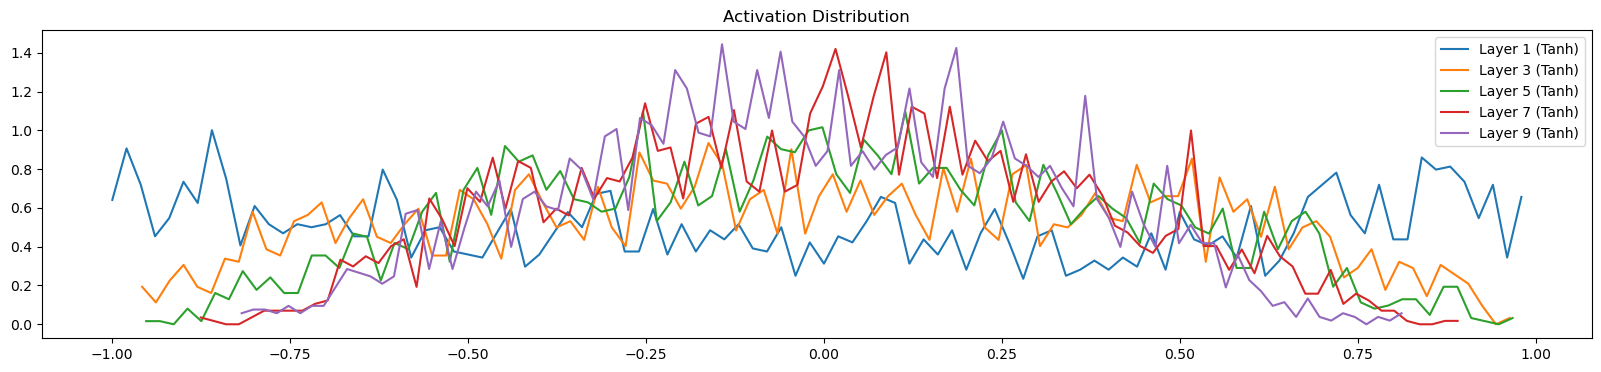

In [54]:
plt.figure(figsize=(20, 4))  # Width and height of the plot
legends = []
# Note: Excluding the output layer, these are all Tanh layers
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' %
              (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'Layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('Activation Distribution')